In [61]:
import open3d as o3d
import numpy as np
import os

HYPERPARAMETER

In [83]:
CLOUD_PATH = '../DATA/tray-b-4-d_L2.pcd'
base_filename = os.path.splitext(os.path.basename(CLOUD_PATH))[0]

OUTPUT_PATH = '../DATA/CREATED_FINAL/' + base_filename +'_'
SAVE_MODE = False #save intermediate steps
FINAL_SAVE_MODE = True #save final clean chips

DOWNSAMPLE_FACTOR = 10
THRESHOLD_FILTER_LARGE_PARTS = 650000
TRIM_TOP = 0.14  # Percentage of the top part to trim
TRIM_BOTTOM = 0.02
SOR_NB_NEIGHBORS = 500#jessica 500
SOR_STD_RATIO = 5 #jessica 5
RANSAC_DISTANCE_THRESHOLD = 120
RANSAC_N = 2000
RANSAC_NUM_ITERATIONS = 1000


In [81]:
def split_chips(pcd):
    # Convert the point cloud to numpy arrays for easier manipulation
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)

    # Get the min and max bounds of the point cloud
    min_bound = points.min(axis=0)
    max_bound = points.max(axis=0)

    # Calculate the range along each axis
    ranges = max_bound - min_bound
    longest_axis_index = np.argmax(ranges)  # Find the index of the longest axis

    # Define midpoints for partitioning along the longest axis
    midpoints = np.linspace(min_bound[longest_axis_index], max_bound[longest_axis_index], num=5)

    # Split the point cloud into 4 parts using the reverse order
    masks = [
        points[:, longest_axis_index] >= midpoints[3],  # Part 1
        (points[:, longest_axis_index] >= midpoints[2]) & (points[:, longest_axis_index] < midpoints[3]),  #Part 2
        (points[:, longest_axis_index] >= midpoints[1]) & (points[:, longest_axis_index] < midpoints[2]),  #Part 3
        points[:, longest_axis_index] < midpoints[1]  #Part 4
    ]

    parts = []
    for mask in masks:
        # Filter points and colors based on the mask
        part_points = points[mask]
        part_colors = colors[mask]

        # Create a new point cloud for each part
        part_pcd = o3d.geometry.PointCloud()
        part_pcd.points = o3d.utility.Vector3dVector(part_points)
        part_pcd.colors = o3d.utility.Vector3dVector(part_colors)

        # Add the part to the list
        parts.append(part_pcd)

    return parts

def filter_large_parts(parts, min_points_threshold=THRESHOLD_FILTER_LARGE_PARTS):
    # Dictionary to store point clouds that meet the condition
    filtered_parts = {}

    for i, part in enumerate(parts):
        # Number of points in the current point cloud
        num_points = np.asarray(part.points).shape[0]
        
        # Check if the point cloud has more than the minimum number of points
        if num_points >= min_points_threshold:
            # Store the point cloud in the dictionary using its original index as the key
            filtered_parts[i] = part

    return filtered_parts


def cut_chip_edges(filtered_parts):
    # Iterate over the filtered parts (a dictionary with index and point clouds)
    trimmed_parts = {}
    
    for index, part_pcd in filtered_parts.items():
        # Convert the point cloud to numpy arrays for easier manipulation
        part_points = np.asarray(part_pcd.points)
        part_colors = np.asarray(part_pcd.colors)
        
        # Get the min and max bounds of the point cloud
        min_bound = part_points.min(axis=0)
        max_bound = part_points.max(axis=0)
        ranges = max_bound - min_bound
        longest_axis_index = np.argmax(ranges)  # Find the index of the longest axis

        # Define endpoints for trimming along the longest axis
        endpoints = np.linspace(min_bound[longest_axis_index], max_bound[longest_axis_index], num=2)
        
        # Set the upper and lower ratios for trimming the edges
        uppernumberratio = TRIM_TOP  # Percentage of the top part to trim
        lowernumberratio = TRIM_BOTTOM  # Percentage of the bottom part to trim

        # Create a mask to filter points and colors
        mask = (
            (endpoints[0] + (endpoints[1] - endpoints[0]) * lowernumberratio) < part_points[:, 1]
        ) & (part_points[:, 1] < endpoints[1] - (endpoints[1] - endpoints[0]) * uppernumberratio)

        # Apply the mask to filter both points and colors
        trimmed_points = part_points[mask]
        trimmed_colors = part_colors[mask]

        # Create a new trimmed point cloud
        trimmed_pcd = o3d.geometry.PointCloud()
        trimmed_pcd.points = o3d.utility.Vector3dVector(trimmed_points)
        trimmed_pcd.colors = o3d.utility.Vector3dVector(trimmed_colors)

        # Add the trimmed point cloud back into a dictionary with the original index
        trimmed_parts[index] = trimmed_pcd
       
    return trimmed_parts

def SOR(chip):
    # Remove noise, SOR removes point outside main structure
    _, ind = chip.remove_statistical_outlier(nb_neighbors=SOR_NB_NEIGHBORS, std_ratio=SOR_STD_RATIO) # jessica_500,5
    inlier_cloud = chip.select_by_index(ind)
    outlier_cloud = chip.select_by_index(ind, invert=True)
    return inlier_cloud, outlier_cloud

def RANSAC(chip, distance_threshold=RANSAC_DISTANCE_THRESHOLD, ransac_n=RANSAC_N, num_iterations=RANSAC_NUM_ITERATIONS):
    # Segment the largest plane using RANSAC
    _, inliers = chip.segment_plane(distance_threshold, ransac_n, num_iterations)
    inlier_cloud = chip.select_by_index(inliers)
    outlier_cloud = chip.select_by_index(inliers, invert=True)
    return inlier_cloud, outlier_cloud

# 
def find_edge_cluster(points):
    
    
    #Sort the point cloud base on the minimum x-axis value, take the least 200 points
    sorted_array = sorted(points, key=lambda x: x[0])
    xmin_set = points[-200:] 
  
    
    #Sort the 200 points base on the minimum z-axis value, select 190 points with lowest z value
    sorted_array = sorted(xmin_set, key=lambda x: x[2])
    zmin_set = sorted_array[-190:]
    
    #Sort the 190 points base on the minimum y-axis(longest) value, select 180 points
    #with lowest z value 
    sorted_y = sorted(zmin_set, key=lambda x: x[1])
    ymin_set = sorted_y[-180:]
    
    #covert this final cluster into np array for visualization
    edge_cluster = ymin_set  
    edge_cluster = np.array(edge_cluster)

    
    # Visulization of the points clusters
    # Extracting x, y, z coordinates from the array
    x = edge_cluster[:, 0]  # First column
    y = edge_cluster[:, 1]  # Second column
    z = edge_cluster[:, 2]  # Third column

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x, y, z)

    # Label axes
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Display the plot
    plt.show()
    
    return edge_cluster



def center_and_normalize(part):
    # Convert point cloud to numpy array
    points = np.asarray(part.points)
    
    # Step 1: Find the edge_cluster using the method described above
    edge_cluster = find_edge_cluster(points)
    
    # Step 2: Align point cloud by subtracting the edge point (mean of the edge_cluster)
    #edge_point = np.mean(edge_cluster, axis=0)
    #print(f"Special point found: {edge_point}")
    centered_points = points - np.mean(edge_cluster,axis=0)

    # Step 3: Normalize the point cloud
    max_distance = np.max(np.linalg.norm(centered_points, axis=1))
    normalized_points = centered_points / max_distance

    # Create a new point cloud with the normalized points
    normalized_pcd = o3d.geometry.PointCloud()
    normalized_pcd.points = o3d.utility.Vector3dVector(normalized_points)
    normalized_pcd.colors = part.colors  # Retain the original colors if needed

    return normalized_pcd

# STEP 1: DOWNSAMPLE

In [84]:
pcd = o3d.io.read_point_cloud(CLOUD_PATH)
pcd

PointCloud with 25634170 points.

In [85]:
# change later to VOXEL DOWNSAMPLING?
downsampled_pcd = pcd.uniform_down_sample(DOWNSAMPLE_FACTOR)
downsampled_pcd

PointCloud with 2563417 points.

In [86]:
if SAVE_MODE:
    o3d.io.write_point_cloud(OUTPUT_PATH + 'downsampled_pcd.ply', downsampled_pcd)

# STEP 2: SPLIT CLOUD in 4 CHIPS

In [87]:
parts = split_chips(downsampled_pcd)
parts 

[PointCloud with 463514 points.,
 PointCloud with 824152 points.,
 PointCloud with 452281 points.,
 PointCloud with 823470 points.]

In [88]:
if SAVE_MODE:
    for i, part in enumerate(parts):
        o3d.io.write_point_cloud(OUTPUT_PATH + f"part_{i+1}.ply", part)

# STEP 3: Filter out empty or manipulated (chips with white paper on top) chips

In [89]:
filtered_parts = filter_large_parts(parts)
filtered_parts

{1: PointCloud with 824152 points., 3: PointCloud with 823470 points.}

In [90]:
# Check if there are any parts left in the dictionary
if len(filtered_parts) == 0:
    raise ValueError("No parts remain after filtering. Please check the filtering criteria.")
else:
    print(f"{len(filtered_parts)} parts remaining after filtering.")

2 parts remaining after filtering.


In [91]:
if SAVE_MODE:
    for index, part in filtered_parts.items():
        o3d.io.write_point_cloud(OUTPUT_PATH + f"filtered_part_{index+1}.ply", part)

# STEP 4: CUT OUT TRAY LABELS {1,2,3,4}

In [92]:
trimmed_parts = cut_chip_edges(filtered_parts)
trimmed_parts

{1: PointCloud with 799363 points., 3: PointCloud with 801782 points.}

In [93]:
if SAVE_MODE:
    for index, part in trimmed_parts.items():
        o3d.io.write_point_cloud(OUTPUT_PATH + f"trimmed_filtered_part_{index+1}.ply", part)

# STEP 5: NOISE REMOVAL

RANSAC

In [94]:
ransac_results = {}

for index, part_pcd in trimmed_parts.items():
    inlier_cloud, outlier_cloud = RANSAC(part_pcd)
        
    ransac_results[index] = {
        'inliers': inlier_cloud,
        'outliers': outlier_cloud
    }

    print(f"Processed part {index+1}: Inliers and Outliers segmented.")

    num_inliers = len(inlier_cloud.points)
    num_outliers = len(outlier_cloud.points)

    print(f"Processed part {index+1}: Inliers = {num_inliers} points, Outliers = {num_outliers} points.")

Processed part 2: Inliers and Outliers segmented.
Processed part 2: Inliers = 761692 points, Outliers = 37671 points.
Processed part 4: Inliers and Outliers segmented.
Processed part 4: Inliers = 764006 points, Outliers = 37776 points.


In [95]:
if SAVE_MODE:
    for index, result in ransac_results.items():
        inliers = result['inliers']
        outliers = result['outliers']
        
        o3d.io.write_point_cloud(OUTPUT_PATH + f"inliers_part_{index+1}.ply", inliers)
        o3d.io.write_point_cloud(OUTPUT_PATH + f"outliers_part_{index+1}.ply", outliers)

SOR

In [96]:
sor_results = {}

# Iterate through RANSAC results
for index, result in ransac_results.items():
    inliers = result['inliers']
    
    # Apply SOR on the inliers from RANSAC
    inlier_cloud_sor, outlier_cloud_sor = SOR(inliers)
    
    # Store the SOR inliers and outliers in the dictionary
    sor_results[index] = {
        'inliers_after_sor': inlier_cloud_sor,
        'outliers_after_sor': outlier_cloud_sor
    }

    # Get the number of points in SOR inliers and outliers
    num_inliers_sor = len(inlier_cloud_sor.points)
    num_outliers_sor = len(outlier_cloud_sor.points)

    # Print the number of points for SOR results
    print(f"Processed part {index+1}: SOR Inliers = {num_inliers_sor} points, SOR Outliers = {num_outliers_sor} points.")


Processed part 2: SOR Inliers = 757774 points, SOR Outliers = 3918 points.
Processed part 4: SOR Inliers = 757265 points, SOR Outliers = 6741 points.


In [97]:
if SAVE_MODE:
    for index, result in sor_results.items():
        inliers_after_sor = result['inliers_after_sor']
        outliers_after_sor = result['outliers_after_sor']
        
        # Save the SOR inliers and outliers
        o3d.io.write_point_cloud(OUTPUT_PATH + f"sor_inliers_part_{index+1}.ply", inliers_after_sor)
        o3d.io.write_point_cloud(OUTPUT_PATH + f"sor_outliers_part_{index+1}.ply", outliers_after_sor)

# STEP 6: CENTER AND NORMALIZE

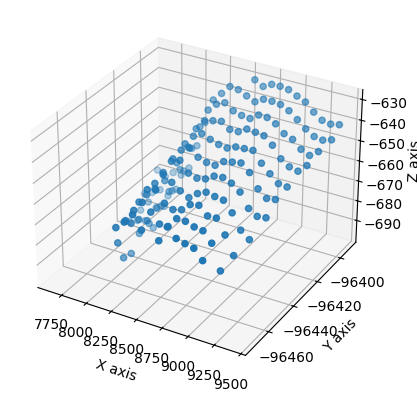

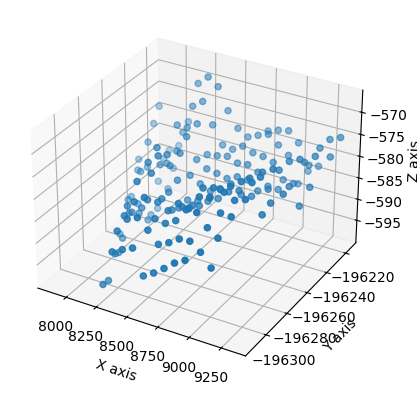

In [98]:
for index, result in sor_results.items():
    inliers = result['inliers_after_sor']

    # Center and normalize each inlier point cloud
    normalized_pcd = center_and_normalize(inliers)

    if FINAL_SAVE_MODE:
    # Save the normalized inlier point cloud as a .ply file
        o3d.io.write_point_cloud(OUTPUT_PATH  +f"_part_{index+1}.ply", normalized_pcd)